In [ ]:
# !git clone https://github.com/HemaxiN/DL_ECG_Classification.git

Cloning into 'DL_ECG_Classification'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 811 (delta 162), reused 204 (delta 127), pack-reused 552 (from 1)
Receiving objects: 100% (811/811), 14.00 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [2]:
!pip install -U -r DL_ECG_Classification/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argon2_cffi-21.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl.metadata (11 kB)
  Using cached debugpy-1.6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached executing-0.8.3-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached fonttools-4.31.2-py3-none-any.whl.metadata (121 kB)
  Using cached importlib_resources-5.6.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached ipykernel-6.

In [ ]:
!pip install -q tifffile pyts wfdb torchmetrics torchsummary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## Validation

### Preprare dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import ast
import pickle
import os


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'validation/'
sampling_rate = 100
Y = pd.DataFrame({
    'ecg_id': [1, 2, 3, 4, 5, 6],
    'filename_lr': [f'validation0{i}' for i in range(1, 7)],
    'scp_codes': [['NORM'], ['AFLT'], ['1dAVB'], ['AFIB'], ['RBBB'], ['LBBB']]
})

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

def aggregate_diagnostic(y, threshold=50):
    return list(y)

# Apply diagnostic superclass
Y['subclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y = Y[Y.subclass.apply(lambda x: len(x) > 0)]

X_test = X
y_test = Y.subclass
print(f'Test records: {len(y_test)}')

Test records: 6


In [2]:
preprocessed_dir = path+'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [47]:
def labelstovector(X, y):
    '''
    Convert the labels in y into vectors:
    Multi-label problem:
    NORM: [0,0,0,0,0]
    AFIB: [1,0,0,0,0]
    AFLT: [0,1,0,0,0]
    1dAVb: [0,0,1,0,0]
    RBBB: [0,0,0,1,0]
    LBBB: [0,0,0,0,1]
    Combination example:
    AFLT and LBBB: [0,1,0,0,1]
    LBBB and RBBB and 1dAVB: [0,0,1,1,1]
    -----------------------------------------------------------
    Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
    '''
    y_list = []
    X_list = []
    for label, ecg in zip(y, X):
        if len(label)!= 0: #ignore examples with label = []
            aux_vec = np.zeros(5)
        if 'AFIB' in label:
            aux_vec[0] = 1
        if 'AFLT' in label:
            aux_vec[1] = 1
        if '1dAVB' in label:
            aux_vec[2] = 1
        if 'RBBB' in label:
            aux_vec[3] = 1
        if 'LBBB' in label:
            aux_vec[4] = 1
    
        y_list.append(aux_vec)
        X_list.append(ecg)
    
    return X_list, y_list

In [4]:
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Test size:', X_test.shape)

Test size: (6, 1000, 12)


In [5]:
# Prepare 2D dataset
!mkdir -p validation/Images/test/labels
!mkdir -p validation/Images/test/images

# Save processed dataset at
!mkdir -p validation/Processed/model_specific/X_rnn_test
!mkdir -p validation/Processed/model_specific/X_cnn_test
!mkdir -p validation/Processed/model_specific/labels_test

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python DL_ECG_Classification/Dataset/create_dataset.py -data validation/Processed -save_dir validation/Processed/model_specific -only_test true

Raw data directory: validation/Processed
Storing processed at: validation/Processed/model_specific
2D processing: 100%|██████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]


Model output (5,)
[0. 0. 0. 0. 0.]

1D input: (1000, 12)
[[ 1.84792383e-01  1.97643631e+00  3.93297812e+00 ...  2.02118208e+00
   4.25170697e+00  5.06987830e+00]
 [ 2.78193742e-01  2.63975027e+00  5.20312044e+00 ...  2.72363984e+00
   5.73813755e+00  6.84241617e+00]
 [ 4.85544124e-01  1.85244336e+00  3.19054604e+00 ...  1.87839375e+00
   3.82608544e+00  4.56233339e+00]
 ...
 [-3.62266125e-01 -6.45191252e-02  4.43847264e-01 ... -2.14905862e-01
  -2.13848833e-01 -7.10615171e-02]
 [-2.37333875e-01  1.65010760e-02  4.09973167e-01 ... -1.89454890e-01
  -1.53902236e-01 -5.74126164e-03]
 [-4.41975302e-01 -4.08976588e-02  6.18472046e-01 ... -1.47319931e-01
  -1.10997307e-01  1.80416413e-02]]

2D input: (256, 256)


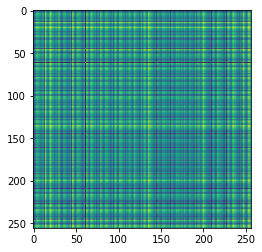

In [6]:
# View label
label = np.load('validation/Processed/model_specific/labels_test/0.npy')
print('Model output', label.shape)
print(label)

# View RNN input
rnn_input = np.load('validation/Processed/model_specific/X_rnn_test/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('validation/Processed/model_specific/X_cnn_test/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

### Evaluate

In [84]:
!python eval_saved_models.py -gpu_id 0 \
    -model gru \
    -path DL_ECG_Classification/Models/GRU \
    -data validation/Processed/model_specific/ \
    -predict_only 1

Predicted probabilities
[[0.01 0.   0.01 0.04 0.  ]
 [0.79 0.81 0.07 0.01 0.  ]
 [0.01 0.01 0.83 0.01 0.01]
 [0.85 0.8  0.17 0.01 0.01]
 [0.53 0.85 0.16 1.   0.02]
 [0.94 0.62 0.37 0.4  0.89]]


In [ ]:
'''
Actual conditions
NORM [0, 0, 0, 0, 0]
AFLT [0, 1, 0, 0, 0]
1dAVB[0, 0, 1, 0, 0]
AFIB [1, 0, 0, 0, 0]
RBBB [0, 0, 0, 1, 0]
LBBB [0, 0, 0, 0, 1]
'''

## Testing

### Prepare dataset

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os

def load_test_data(df, path):
    data = np.array([np.load(os.path.join(path, file)) for file in df.filename_lr])
    return data

path = 'test/'
Y = pd.DataFrame({
    'ecg_id': [1, 2, 3, 4, 5, 6],
    'filename_lr': [f'test0{i}.npy' for i in range(1, 7)],
    'scp_codes': [['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM'], ['NORM']]
})

# Load raw signal data
X_test = load_test_data(Y, path).reshape(6, 1000, 12)

In [39]:
preprocessed_dir = path+'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [40]:
def labelstovector(X, y):
    '''
    Convert the labels in y into vectors:
    Multi-label problem:
    NORM: [0,0,0,0,0]
    AFIB: [1,0,0,0,0]
    AFLT: [0,1,0,0,0]
    1dAVb: [0,0,1,0,0]
    RBBB: [0,0,0,1,0]
    LBBB: [0,0,0,0,1]
    Combination example:
    AFLT and LBBB: [0,1,0,0,1]
    LBBB and RBBB and 1dAVB: [0,0,1,1,1]
    -----------------------------------------------------------
    Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
    '''
    y_list = []
    X_list = []
    for label, ecg in zip(y, X):
        if len(label)!= 0: #ignore examples with label = []
            aux_vec = np.zeros(5)
        if 'AFIB' in label:
            aux_vec[0] = 1
        if 'AFLT' in label:
            aux_vec[1] = 1
        if '1dAVB' in label:
            aux_vec[2] = 1
        if 'RBBB' in label:
            aux_vec[3] = 1
        if 'LBBB' in label:
            aux_vec[4] = 1
    
        y_list.append(aux_vec)
        X_list.append(ecg)
    
    return X_list, y_list

In [41]:
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Test size:', X_test.shape)

Test size: (6, 1000, 12)


In [42]:
# Prepare 2D dataset
!mkdir -p test/Images/test/labels
!mkdir -p test/Images/test/images

# Save processed dataset at
!mkdir -p test/Processed/model_specific/X_rnn_test
!mkdir -p test/Processed/model_specific/X_cnn_test
!mkdir -p test/Processed/model_specific/labels_test

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python DL_ECG_Classification/Dataset/create_dataset.py -data test/Processed -save_dir test/Processed/model_specific -only_test true

Raw data directory: test/Processed
Storing processed at: test/Processed/model_specific
2D processing: 100%|██████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]



1D input: (1000, 12)
[[-0.75929094 -0.71752012 -0.65710717 ... -0.30238529 -0.13966072
  -0.38721662]
 [-0.93984921 -0.94381554 -0.91542578 ... -0.73971369 -0.74750767
  -0.86558225]
 [-0.81764305 -0.79268557 -0.62190067 ... -0.87577415 -1.07462407
  -0.91909768]
 ...
 [-0.4190727  -0.5635605  -0.38010617 ... -0.59550104 -0.4501746
  -0.06406167]
 [-0.10511532 -0.15824024  0.04397408 ...  0.58909192  0.53271988
   0.5976678 ]
 [ 0.51499232  0.57042477  0.6490706  ... -0.41516576 -0.31925996
   0.08753016]]

2D input: (256, 256)


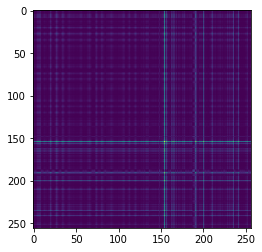

In [18]:
# View RNN input
rnn_input = np.load('test/Processed/model_specific/X_rnn_test/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('test/Processed/model_specific/X_cnn_test/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

### Evaluate

In [75]:
!python eval_saved_models.py -gpu_id 0 \
    -model resnet \
    -datatype cnn \
    -path DL_ECG_Classification/Models/ResNet \
    -data test/Processed/model_specific/ \
    -predict_only 1

Predicted probabilities
[[0.58 0.92 0.39 0.5  0.56]
 [0.41 0.94 0.55 0.45 0.59]
 [0.54 0.88 0.67 0.58 0.73]
 [0.52 0.92 0.54 0.61 0.64]
 [0.44 0.93 0.57 0.59 0.82]
 [0.46 0.93 0.58 0.34 0.73]]


In [ ]:
# NORM: [0,0,0,0,0]
# AFIB: [1,0,0,0,0]
# AFLT: [0,1,0,0,0]
# 1dAVb: [0,0,1,0,0]
# RBBB: [0,0,0,1,0]
# LBBB: [0,0,0,0,1]

# 01: NORM
# 02: AFLT
# 03: 1dAVB
# 04: AFIB
# 05: RBBB
# 06: LBBB